In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding = 'iso-8859-1')

### DATA WRANGLING

The first thing we need to do is group total visits by a seven day period and then by user id from __engagement__. From here, we will choose the max amount of visits from each 7-day period by each user and create a target feature __adopted_user__ where 1 represents a user being adopted and 0 not being adopted.

In [3]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
#change time_stamp to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [5]:
#group by a seven day period and user id and sum total visits in each seven day period
e_grouped = pd.DataFrame(engagement.groupby([pd.Grouper(key='time_stamp', freq='7D'), 'user_id'])['visited'].sum())

#find the maximum number of visits from each period and group by user id
e_grouped = pd.DataFrame(e_grouped.groupby('user_id')['visited'].max())

#reset the index
e_grouped.reset_index(inplace=True)

In [6]:
#create a label for adopted users
e_grouped['adopted_user'] = 0

for i in range(len(e_grouped)):
    if e_grouped.visited[i] >= 3:
        e_grouped.adopted_user[i] = 1
        
#rename the columns for merging
e_grouped.rename(columns={'user_id':'object_id', 'visited': 'max_visits'}, inplace=True)

In [7]:
e_grouped.head()

,object_id,max_visits,adopted_user
0,1,1,0
1,2,2,0
2,3,1,0
3,4,1,0
4,5,1,0


In [8]:
#merge with users
users = users.merge(e_grouped, how='left', on='object_id')

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  max_visits                  8823 non-null   float64
 11  adopted_user                8823 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.2+ MB


Let's now pre-process the users info and fill in any missing information.

In [10]:
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time)

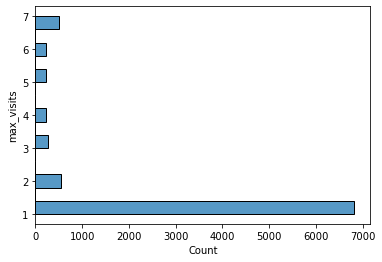

In [11]:
sns.histplot(y=users.max_visits)
plt.show()

We need to impute the number of __max_visits__. Here we can see that majority of visits are less than 2. It will make more sense to use the median as the mean will be affected by outliers like 6 and 7 visits. We will then impute the remaning labels for __adopted_user__.

In [12]:
users.max_visits.fillna(users.max_visits.median(), inplace=True)

#impute the remaining adopted_user labels
if users.max_visits.median() < 3:
    users.adopted_user.fillna(0, inplace=True)
else:
    users.adopted_user.fillna(1, inplace=True)
    
#adjust dtype for max_visits and adopted_user
users = users.astype({'max_visits':'int64', 'adopted_user':'int64'})

Since __last_session_creation_time__ shows that the last session created was in 1970, this may imply that a user hasn't logged on or there is an error in the way the data is collected.

We will drop __creation_time__ and __last_session_creation_time__ from our dataset as well as other identifying factors like __object_id__, __name__, and __email__ as these are identifiers and not features. __org_id__ may be useful as we don't know whether the organization a user is a part of affects how likely a user is to adopt.

We will then create and add another column __invited_by_user__ that is a boolean value for __invited by_user_id__ so that we may use this as a potential feature. We will then turn __creation_source__ into a dummy variable.

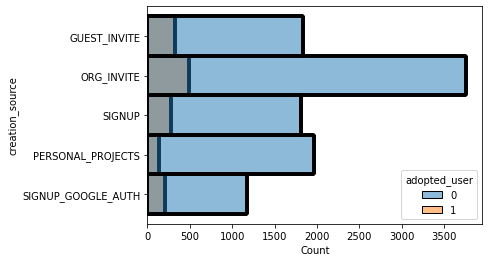

In [13]:
sns.histplot(y=users.creation_source, hue=users.adopted_user)
plt.show()

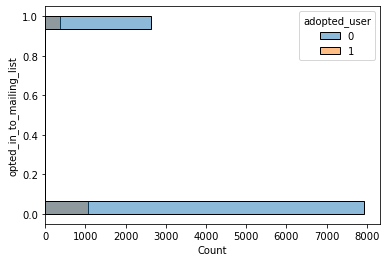

In [14]:
sns.histplot(y=users.opted_in_to_mailing_list, hue=users.adopted_user)
plt.show()

In [15]:
no_mail = users.opted_in_to_mailing_list == 0
no_mail_1 =  len(users.loc[(users.adopted_user == 1) & (no_mail)])/len(users[no_mail])
no_mail_0 =  len(users.loc[(users.adopted_user == 0) & (no_mail)])/len(users[no_mail])

print('no mailing list, adopted_user: ', no_mail_1)
print('no malining list, unadopted_user: ', no_mail_0)

no mailing list, adopted_user:  0.11947590495225405
no malining list, unadopted_user:  0.880524095047746


In [16]:
mail = users.opted_in_to_mailing_list == 1
mail_1 = len(users.loc[(users.adopted_user == 1) & (mail)])/len(users[mail])
mail_0 = len(users.loc[(users.adopted_user == 0) & (mail)])/len(users[mail])

print('mailing list, adopted_user: ', mail_1)
print('malining list, unadopted_user: ', mail_0)

mailing list, adopted_user:  0.12324649298597194
malining list, unadopted_user:  0.8767535070140281


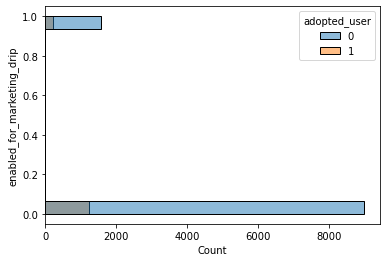

In [17]:
sns.histplot(y=users.enabled_for_marketing_drip, hue=users.adopted_user)
plt.show()

In [18]:
print('no drip, adopted_user: ', len(users.loc[(users.adopted_user == 1) & (users.enabled_for_marketing_drip == 0)])/len(users[users.enabled_for_marketing_drip == 0]))
print('no drip, unadopted_user: ', len(users.loc[(users.adopted_user == 0) & (users.enabled_for_marketing_drip == 0)])/len(users[users.enabled_for_marketing_drip == 0]))

no drip, adopted_user:  0.12010188087774294
no drip, unadopted_user:  0.879898119122257


In [19]:
print('enabled drip, adopted_user: ', len(users.loc[(users.adopted_user == 1) & (users.enabled_for_marketing_drip ==1)])/len(users[users.enabled_for_marketing_drip ==1]))
print('enabled drip, unadopted_user: ', len(users.loc[(users.adopted_user == 0) & (users.enabled_for_marketing_drip ==1)])/len(users[users.enabled_for_marketing_drip ==1]))

enabled drip, adopted_user:  0.12220982142857142
enabled drip, unadopted_user:  0.8777901785714286


We can see from __enabled_for_marketing_drip__ and __opted_into_mailing_list__ that the number of adopted users slightly increases when both labels are true.

In [20]:
#fill missing values with 0 for invited_by_user_id
users.invited_by_user_id.fillna(0, inplace=True)

#create invited_by_user column and set to 0
users['invited_by_user'] = 0

#relabeled invited_by_user to 1 if a user has been invited by a previous existing user
for i in range(len(users)):
    if users.invited_by_user_id[i] > 0:
        users.invited_by_user[i] = 1
    else:
        users.invited_by_user[i] = 0

<ipython-input-20-cb33c7120c31>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.invited_by_user[i] = 1
<ipython-input-20-cb33c7120c31>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.invited_by_user[i] = 0


In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  max_visits                  12000 non-null  int64         
 11  adopted_user                12000 non-null  int64     

In [22]:
df = users.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'invited_by_user_id'], axis=1)
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,max_visits,adopted_user,invited_by_user
0,GUEST_INVITE,1,0,11,1,0,1
1,ORG_INVITE,0,0,1,2,0,1
2,ORG_INVITE,0,0,94,1,0,1
3,GUEST_INVITE,0,0,1,1,0,1
4,GUEST_INVITE,0,0,193,1,0,1


We will now create dummy variables for __creation_source__ and reinsert the __adopted_user__ labels

In [23]:
adopted_user = df.pop('adopted_user')
df = pd.get_dummies(df)
df['adopted_user'] = adopted_user

Let's now correlate the features to the target label to see which features are most important in predicting adoption.

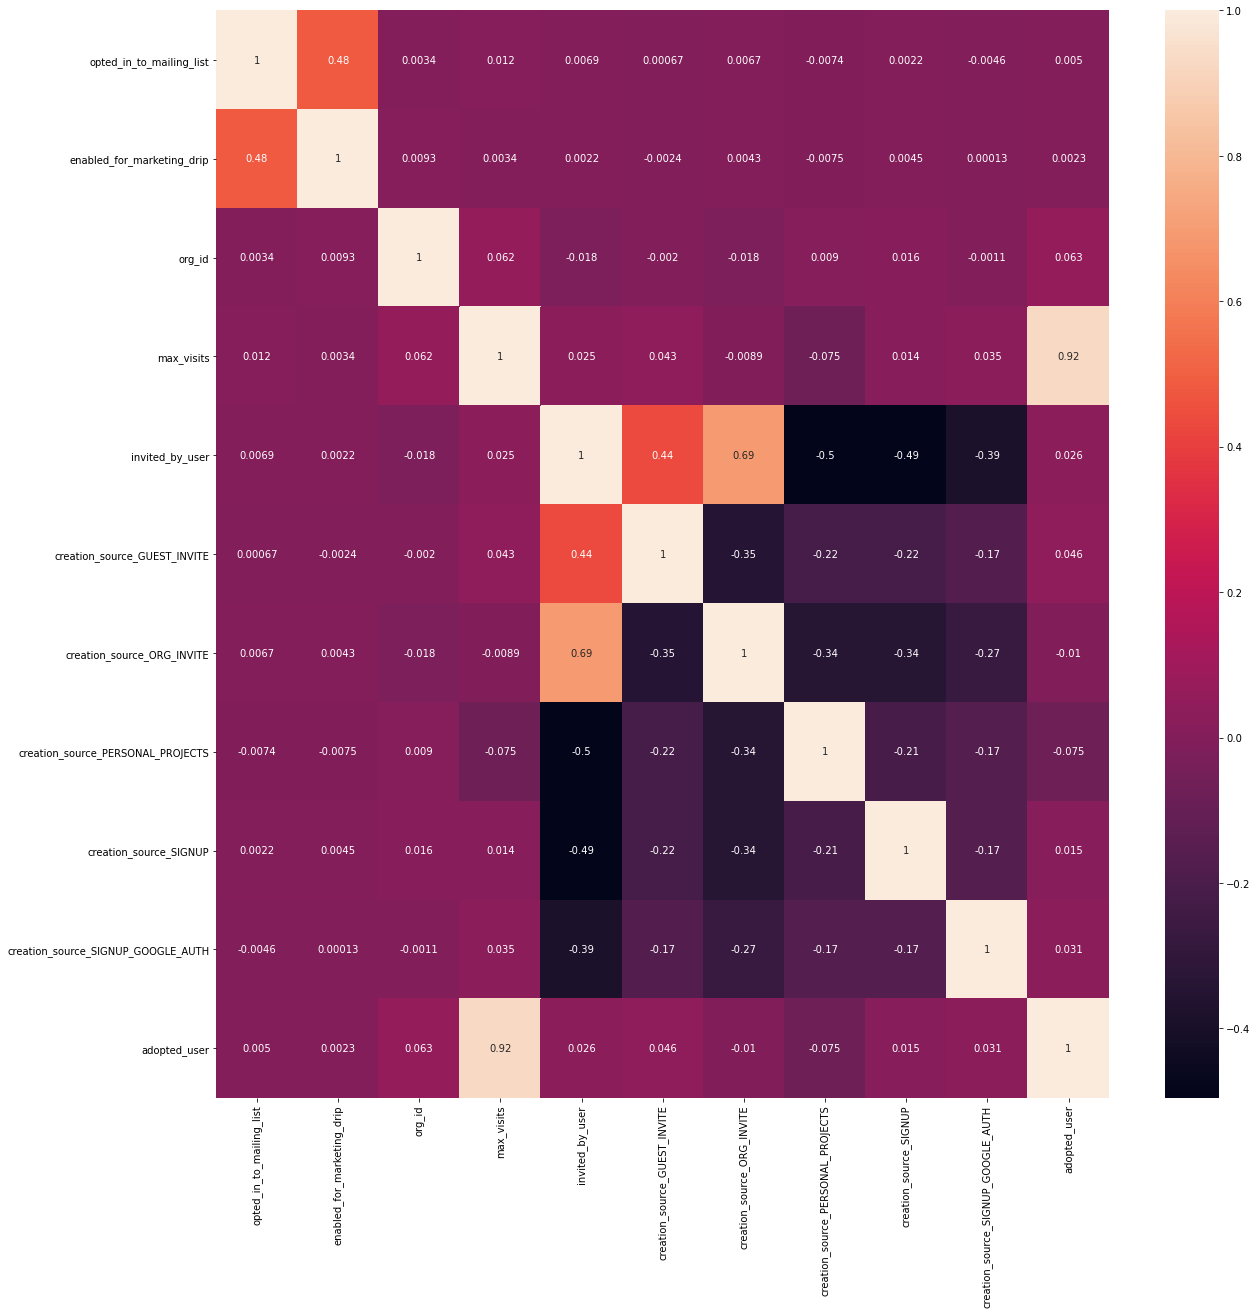

In [24]:
#get correlations of each features in dataset
corrdf = df.corr()
features = corrdf.index
plt.figure(figsize=(20,20))

#plot heat map
_=sns.heatmap(df[features].corr(), annot=True)

Based on the above, the largest predictor for adopted user is of course the number of visits. However, this is highly correlated with the __adopted_user__ target feature since that is what we used to determine our labels.

Other than this, user creation source and which organization each user is from are slightly strong predictors in whether a user will adopt. User creation brought on via Guest Invite or using Google Authentication are the strongest predictors from __creation_source__.

This suggests that users are more likely to adopt via a referral or if they have a Google Account.

Because the labels are imbalanced we may get a clearer picture of the data by transforming it. We could try downsampling false values or oversampling true values, using a log transforming, or standardizing the data.